<a href="https://colab.research.google.com/github/makingthefuturehappy/NNs/blob/main/CNN_Car_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

results:<br>
v1.0 'Xception': loss: 0.1225 | accuracy: 0.9696 | submission - 0.93018<br>
v1.1. 'Xception' with LR optimization & Batch Optimization: loss: 0.1470 |  accuracy: 0.9693 | submission - 0.93962<br>
v2.0 'EfficientNetB4' with LR optimization & Batch Optimization loss: 0.3996 | accuracy: 0.9568 | submission - 0.93018<br>
v3.0 'InceptionResNetV2' with LR optimization & Batch Optimization + dataset v3 loss: 0.1252 | accuracy: 0.9926 | submission - 0.96044<br>
v3.0 'InceptionResNetV2' with LR optimization & Batch Optimization + dataset v3 + ds v4 loss: 0.0704 - accuracy: 0.9881 | submission - 0.96029


In [16]:
#@title Libs and Drivers setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os
import shutil
import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import EfficientNetB4

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
%config IPCompleter.greedy=True  # более лучший автокомплит в блокноте

from google.colab import drive
drive.mount('/content/drive')
file_path = 'https://drive.google.com/drive/folders/1Sc9qSYEE4Mf2z1MVccxwcUCW3MqTdnwa'

from google.colab import output
def Notification():
  output.eval_js('new Audio("https://soundslibmp3.ru/sounds/1599371653_intro-35.mp3").play()')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
#@title system check
Notification()
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)
tf.test.gpu_device_name() ## Проверяем что у нас работает GPU
!nvidia-smi -L ##GPU count and name

Python       : 3.6.9 (default, Jul 17 2020, 12:50:27) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0
Keras        : 2.4.0
GPU 0: Tesla T4 (UUID: GPU-ebe6e20d-2b53-bbf4-da02-9056848b6853)


In [18]:
EPOCHS               = 7  # эпох на обучение
BATCH_SIZE           = 256 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

PATH = '/content/'
PATH_GDRIVE = '/content/drive/My Drive/Colab Notebooks/car classification/data/'

# Устаналиваем конкретное значение random seed для воспроизводимости
# os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

In [19]:
# @title Dataset Setup
print('unpacking the pics...')

# train DataSet Setup
print('unpacking train dataset...')
with zipfile.ZipFile(PATH_GDRIVE + 'train/' + 'aug_train_v3.zip',"r") as z:
  z.extractall(PATH + 'train')

## test DataSet Setup
print('unpacking test dataset...')
with zipfile.ZipFile(PATH_GDRIVE + 'test/test_upload.zip',"r") as z:
        z.extractall(PATH)

## copy files from G-Drive to Colab env.
%cp -av '/content/drive/My Drive/Colab Notebooks/car classification/data/train.csv' '/content'
%cp -av '/content/drive/My Drive/Colab Notebooks/car classification/data/sample-submission.csv' '/content'

print('cleaning folders...')
shutil.rmtree(PATH + 'train/__MACOSX')
shutil.rmtree(PATH + '__MACOSX')
# shutil.rmtree(PATH + 'sample_data')
print('data uploaded...')
Notification()

unpacking the pics...
unpacking train dataset...
unpacking test dataset...
'/content/drive/My Drive/Colab Notebooks/car classification/data/train.csv' -> '/content/train.csv'
'/content/drive/My Drive/Colab Notebooks/car classification/data/sample-submission.csv' -> '/content/sample-submission.csv'
cleaning folders...
data uploaded...


In [ ]:
# @title Delete all internal directories (muted)
# import shutil

# for dir_name in range (0,9,1):
#   dir_name = str(dir_name)
#   try:
#     shutil.rmtree('/content/' + str(dir_name))
#   except: print(dir_name, 'dir does not exist')

# try:
#   shutil.rmtree('/content/' + str('__MACOSX'))
# except: print(dir_name, 'dir does not exist')

# try:
#   shutil.rmtree(PATH + 'train/')
#   shutil.rmtree(PATH + 'test_upload/')
# except: print('deleting all files error')

# print('allDone')

In [ ]:
#@title Random pics examples (muted)
# print('random pics examples')

# train_df = pd.read_csv(PATH+"train.csv")
# sample_submission = pd.read_csv(PATH+"sample-submission.csv")
# print('dataset examples\n',
#       train_df.head(),
#       '\n\ncategories destribution\n',
#       train_df.Category.value_counts())

# plt.figure(figsize=(12,8))

# random_image = train_df.sample(n=9)
# random_image_paths = random_image['Id'].values
# random_image_cat = random_image['Category'].values

# for index, path in enumerate(random_image_paths):
#     im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
#     plt.subplot(3,3, index+1)
#     plt.imshow(im)
#     plt.title('Class: '+str(random_image_cat[index]))
#     plt.axis('off')
# plt.show()

In [20]:
#@title Pics Generator setup
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=VAL_SPLIT, # set validation split
    ##pics augumentation
    # horizontal_flip=False
    # rotation_range = 5,
    # width_shift_range=0.1,
    # height_shift_range=0.1
    )

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    PATH + 'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH + 'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

sample_submission = pd.read_csv(PATH+"sample-submission.csv")
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

test_datagen = ImageDataGenerator(rescale=1. / 255)

Found 115455 images belonging to 10 classes.
Found 20368 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
#@title Tensorboard load
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
!rm -rf ./logs/
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [21]:
#@title plot_result function
def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()  
    return

In [ ]:
#@title NN_v1.0 Xception (setup)
model_name = 'v1_0.hdf5'
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)
# New head setup
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [ ]:
#@title NN_v1.0 Xception (training)
checkpoint = ModelCheckpoint(model_name ,
                             monitor = ['val_accuracy'],
                             verbose = 1, 
                             mode = 'max')
callbacks_list = [checkpoint]

history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks=[tensorboard_callback]
        )

model.save(PATH_GDRIVE + "models/" + model_name)
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("\nAccuracy: %.2f%%" % (scores[1]*100))

In [ ]:
#@title NN_v1.1 Xception with LR optimization & Batch Optimization (setup)
%reload_ext tensorboard
model_name = 'v1_1.hdf5'
!rm -rf ./logs/
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1)

base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(100, activation='relu', kernel_regularizer = 'l2')(x)
x = BatchNormalization()(x)
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.0005, 
                                                                                            decay_steps = 100, 
                                                                                            decay_rate = 0.9)),
                                        metrics=["accuracy"])

checkpoint = ModelCheckpoint(model_name , 
                             monitor = ['val_accuracy'] , 
                             verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1, # new_lr = lr * factor. 
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001, cooldown=1, min_lr=0)

In [ ]:
#@title NN_v1.1 Xception with LR optimization & Batch Optimization (training)
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list)

model.save(PATH_GDRIVE + 'models/' + model_name)
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("\nAccuracy: %.2f%%" % (scores[1]*100))
%tensorboard --logdir logs/fit

## EfficientNetB4

#### ReduceLROnPlateau

In [ ]:
#@title NN_v3.0 'InceptionResNetV2' with LR optimization & Batch Optimization (setup)
from tensorflow.keras.applications import InceptionResNetV2

model_name = 'v3_0_ds4.hdf5'
base_model = InceptionResNetV2(input_shape=input_shape,
                          include_top=False,
                          weights="imagenet")
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(100, activation='relu', kernel_regularizer = 'l2')(x)
x = BatchNormalization()(x)
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.0005, 
                                                                                            decay_steps = 100, 
                                                                                            decay_rate = 0.9)),
                                        metrics=["accuracy"])

checkpoint = ModelCheckpoint(model_name , 
                             monitor = ['val_accuracy'] , 
                             verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1, # new_lr = lr * factor. 
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001, cooldown=1, min_lr=0)

219062272/219055592 [==============================] - 2s 0us/step


Epoch 1/7
1804/1804 [==============================] - ETA: 0s - loss: 0.7376 - accuracy: 0.8694
Epoch 00001: saving model to v3_0_ds4.hdf5
1804/1804 [==============================] - 2134s 1s/step - loss: 0.7376 - accuracy: 0.8694 - val_loss: 0.1346 - val_accuracy: 0.9756
Epoch 2/7
1804/1804 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.9701
Epoch 00002: saving model to v3_0_ds4.hdf5
1804/1804 [==============================] - 2121s 1s/step - loss: 0.1254 - accuracy: 0.9701 - val_loss: 0.0691 - val_accuracy: 0.9886
Epoch 3/7
1804/1804 [==============================] - ETA: 0s - loss: 0.0572 - accuracy: 0.9919
Epoch 00003: saving model to v3_0_ds4.hdf5
1804/1804 [==============================] - 2127s 1s/step - loss: 0.0572 - accuracy: 0.9919 - val_loss: 0.0710 - val_accuracy: 0.9879
Epoch 4/7
1804/1804 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9951
Epoch 00004: saving model to v3_0_ds4.hdf5
1804/1804 [========================

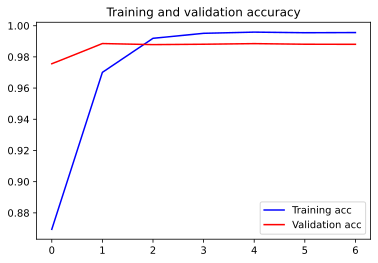

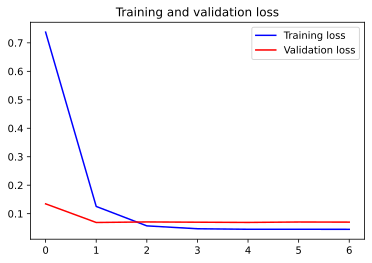

In [ ]:
#@title NN_v3.0 'InceptionResNetV2' with LR optimization & Batch Optimization (training)

history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list)

model.save(PATH_GDRIVE + 'models/' + model_name)

scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("\nAccuracy: %.2f%%" % (scores[1]*100))
plot_result(history)
Notification()

#### without ReduceLROnPlateau

In [ ]:
#@title NN_v3.1 'InceptionResNetV2' with No LR optimization & Batch Optimization (setup)
from tensorflow.keras.applications import InceptionResNetV2

model_name = 'v3_1_ds2.hdf5'
base_model = InceptionResNetV2(input_shape=input_shape,
                          include_top=False,
                          weights="imagenet")
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(100, activation='relu', kernel_regularizer = 'l2')(x)
x = BatchNormalization()(x)
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.0005, 
                                                                                            decay_steps = 100, 
                                                                                            decay_rate = 0.9)),
                                        metrics=["accuracy"])

checkpoint = ModelCheckpoint(model_name , 
                             monitor = ['val_accuracy'] , 
                             verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
#@title NN_v3.1 'InceptionResNetV2' with No LR optimization & Batch Optimization (training)

history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list)

model.save(PATH_GDRIVE + 'models/' + model_name)

scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("\nAccuracy: %.2f%%" % (scores[1]*100))
plot_result(history)

### Fine-Tuning

In [22]:
#@title NN_v3.2 'InceptionResNetV2' with LR & Batch Optimization + FineTuning (setup)

from tensorflow.keras.applications import InceptionResNetV2

model_name = 'v3_2_ds4.hdf5'
base_model = InceptionResNetV2(input_shape=input_shape,
                          include_top=False,
                          weights="imagenet")
# Freeze the base_model
base_model.trainable = False

x = base_model.output
x = BatchNormalization()(x, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(100, activation='relu', kernel_regularizer = 'l2')(x)
x = BatchNormalization()(x)
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(0.0005, 
                                                                                            decay_steps = 100, 
                                                                                            decay_rate = 0.9)),
                                        metrics=["accuracy"])

checkpoint = ModelCheckpoint(model_name , 
                             monitor = ['val_accuracy'] , 
                             verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
#@title NN_v3.2 'InceptionResNetV2' with LR & Batch Optimization + FineTuning (training)
history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list)

model.save(PATH_GDRIVE + 'models/' + model_name)

scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("\nAccuracy: %.2f%%" % (scores[1]*100))
plot_result(history)

In [ ]:
#@title NN_v3.2 'InceptionResNetV2' with LR & Batch Optimization + FineTuning (fine-tuning)
model_name = 'v3_2_ds4_finetuned.hdf5'
base_model.trainable = True
model.compile(loss="categorical_crossentropy",
              optimizer=optimizers.Adam(1e-5))

checkpoint = ModelCheckpoint(model_name , 
                             monitor = ['val_accuracy'] , 
                             verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list)

model.save(PATH_GDRIVE + 'models/' + model_name)

scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("\nAccuracy: %.2f%%" % (scores[1]*100))
plot_result(history)

## submission generator

In [ ]:
model.load_weights(PATH_GDRIVE + 'models/'+
                  #  'v1_0.hdf5',
                  #  'v1_1.hdf5',
                  #  'v2_0.hdf5',
                  #  'v3_0.hdf5',
                  #  'v3_1.hdf5',
                  #  'v3_0_ds3.hdf5',
                  #  'v3_0_ds4.hdf5',
                   'v3_2_ds4_finetuned.hdf5'
                   )
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

test_sub_generator.reset()
predictions = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv(PATH_GDRIVE + 'submission.csv', index=False)
print('Submit saved.')
Notification()

In [ ]:
import os, signal
os.kill(os.getpid(),signal.SIGKILL)